In [ ]:
#Example code is from from 04_13_22_Quickdraw_2_Layer_Wopt2_retrained_today

In [1]:
#Library for DMD control
from ALP4 import *

#Standard Imports
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy import ndimage
from PIL import Image

#PyTorch Imports (not needed for data collection)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision

#Library for LCD control
import slmpy
import wx

#Monitoring Camera 1 & 2 Imports
from Bassler_camera import Spectrometer
from pypylon import pylon

#Monitoring Camera 3 Imports
from pyvcam import pvc
from pyvcam.camera import Camera
from pyvcam import constants as const
## Initiate the camera
pvc.init_pvcam()

True

In [2]:
#Image filtering Imports
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import threshold_otsu, threshold_local

In [3]:
'''defining a local thresholding function - adapted from 
https://www.programcreek.com/python/example/117422/skimage.filters.threshold_local'''

def local_thresholding(im, padding=0, block_size=41, offset= 0):
    """Local thresholding

    Parameters
    ----------
    im :
        The camera frame with the eyes
    padding :
        padding of the camera frame (Default value = 2)
    block_size :
        param offset: (Default value = 17)
    offset :
         (Default value = 70)

    Returns
    -------
    type
        thresholded image

    """
    return im > threshold_local(im, block_size=block_size, offset=offset)

In [4]:
#Load DMD

#Load the Vialux .dll
DMD = ALP4(version = '4.3')
#Initialize the device
DMD.Initialize()
print(DMD._ALPLib)

Loading library: C:\Program Files\ALP-4.3/ALP-4.3 API/x64/alp4395.dll
<CDLL 'C:\Program Files\ALP-4.3\ALP-4.3 API\x64\alp4395.dll', handle 7ffac9f00000 at 0x1b1a6a4c7f0>
DMD found, resolution = 1280 x 800.
<CDLL 'C:\Program Files\ALP-4.3\ALP-4.3 API\x64\alp4395.dll', handle 7ffac9f00000 at 0x1b1a6a4c7f0>


In [5]:
#Load LCD

Sony = slmpy.SLMdisplay(monitor = 1, isImageLock = True)
resX, resY = Sony.getSize()
print(resX)
print(resY)
n_rows = 1024
n_cols = 768

1024
768


C:\Users\mcmah\Anaconda3\envs\ONN_Smart_Sensor\lib\site-packages\slmpy-0.2.0-py3.9.egg\slmpy\slmpy.py:86: wxPyDeprecationWarning: Using deprecated class. Use Cursor instead.
  cursor = wx.StockCursor(wx.CURSOR_BLANK)


In [6]:
#Load LCD Weights

LCD_weights = np.load('LCD_Weights_1600_4_nonlinear.npz')['weights1']
print(LCD_weights.shape)

(36, 1600)


In [7]:
#Load shifts from pre-defined positions of fan-out copies on LCD

movements = np.load('Optimized_LCD_movements_quickdraw.npz')['movements']
print(movements)
print(movements.shape)

[[ 0  0]
 [-1  0]
 [-1  0]
 [ 1  0]
 [ 0  0]
 [-1  0]
 [ 0  0]
 [ 0  0]
 [-1  0]
 [-1  0]
 [ 0  0]
 [-1  0]
 [ 1  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]
 [-1  0]
 [ 1  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]
 [ 0  0]
 [ 2  0]
 [ 1  0]
 [ 1  0]
 [-1  0]
 [ 0  0]
 [-1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [-1  0]
 [ 0  0]]
(36, 2)


In [8]:
#Initialize array to upload on LCD
array = np.zeros((n_cols, n_rows))

#The following 3 parameters define the predefined positions of the fan-out copies on the LCD
top_left_corner = [387, 409]
width = 40
spacing = 62.3

#Uploading transparent boxes on the LCD to see fan-out copies
for i in range (-5, 6):
    for j in range (-5, 7):
        p = i + 5
        q = 5 + j
        if(p in [0, 2, 4, 6, 8, 10] and q in [1, 3, 5, 7, 9, 11]):
            a = int(p/2)
            b = int((11 - q)/2)
            array[top_left_corner[0] + int(i*spacing) + movements[6*a + b][0] \
                  : top_left_corner[0] + width + int(i*spacing) + movements[6*a + b][0], \
                  top_left_corner[1] + int(j*spacing) + movements[6*a + b][1] \
                  : top_left_corner[1] + width + int(j*spacing) + movements[6*a + b][1]] = \
            255            
array = (array).astype(np.uint8)
Sony.updateArray(array)

In [9]:
#Code to create and display a box of size 100 x 100 pixels on the DMD

arr = np.zeros((200, 200))
okl = np.ones((100, 100))
arr[int((arr.shape[0] - okl.shape[0])/2):int((arr.shape[0] + okl.shape[0])/2),\
      int((arr.shape[0] - okl.shape[1])/2):int((arr.shape[0] + okl.shape[1])/2)] = okl
rot_fig = np.maximum(ndimage.rotate(np.fliplr(arr), -45, reshape = False), 0)
rot_fig = np.minimum(rot_fig, 1)
rot_fig = np.fliplr(np.flipud(rot_fig))
scale_im = (rot_fig - np.min(rot_fig))/(np.max(rot_fig) - np.min(rot_fig))
array = np.zeros((800, 1280))
array[int((800 - arr.shape[0])/2):int((800 + arr.shape[0])/2),\
      int((1280 - arr.shape[0])/2):int((1280 + arr.shape[0])/2)] = scale_im
array = (255.*(array)).astype(np.uint8)
bitDepth = 1
# Allocate the onboard memory for the image sequence
DMD.SeqAlloc(nbImg = 1, bitDepth = bitDepth)
# Send the image sequence as a 1D list/array/numpy array
DMD.SeqPut(imgData = array.ravel())
# Set image rate to 5 Hz
# DMD.SetTiming(pictureTime = 5000)
DMD.Run()

In [10]:
#Defining exposure and region of interest on monitoring camera 1

exp_bassler = 100000 #in usec
roi_bassler = [470, 2600, 900, 3030]

In [11]:
#Initializing monitoring cameras 1 and 2

tl_factory = pylon.TlFactory.GetInstance()
devices = tl_factory.EnumerateDevices()
print(devices[0])
for device in devices:
    print(device)
    print(device.GetFriendlyName())

<pypylon.pylon.DeviceInfo; proxy of <Swig Object of type 'Pylon::CDeviceInfo *' at 0x000001B1A6A104E0> >
<pypylon.pylon.DeviceInfo; proxy of <Swig Object of type 'Pylon::CDeviceInfo *' at 0x000001B1A6A104E0> >
Basler acA4024-29um (23979302)
<pypylon.pylon.DeviceInfo; proxy of <Swig Object of type 'Pylon::CDeviceInfo *' at 0x000001B1B0F5AC90> >
Basler acA3088-57um (24246457)


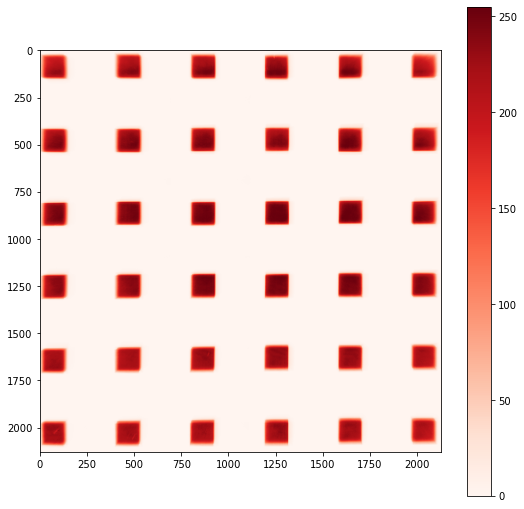

In [12]:
#Getting an image on monitoring camera 1 of positions of fan-out copies (using the box displayed on the DMD)

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler
img_ls = bassler_cam.take_imgs(5)
image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]
bassler_cam.camera.Close()

plt.figure(figsize=(9,9))
plt.imshow(np.array(image), cmap = 'Reds')
plt.colorbar()
plt.show()
np.savez('I0_reference_before_intensifier_DC.npz', image = image)
I0 = np.copy(image)

In [13]:
#Extracting positions of fanned-out copies from above image

thresholded = np.heaviside(I0 - 30, 0)
lines = [90, 470, 870, 1260, 1640, 2030]
lines_v = [90, 490, 880, 1280, 1670, 2050]
x_inds = []
y_inds = []
for i in range (6):
    temp = []
    mem = 0
    for j in range (thresholded[lines[i]].shape[0]):
        if(thresholded[lines[i]][j] == 1 and mem == 0):
            if(j < 100):
                temp.append(j)
            elif(j - temp[-1] > 300):
                temp.append(j)
            mem = 1
        if(thresholded[lines[i]][j] == 0 and mem == 1):
            mem = 0
    x_inds.append(temp)
    
for i in range (6):
    temp = []
    mem = 0
    for j in range (thresholded[:, lines_v[i]].shape[0]):
        if(thresholded[j][lines_v[i]] == 1 and mem == 0):
            if(j < 35):
                temp.append(j)
            elif(j - temp[-1] > 300):
                temp.append(j)
            mem = 1
        if(thresholded[j][lines_v[i]] == 0 and mem == 1):
            mem = 0
    y_inds.append(temp)
    
x_inds = np.array(x_inds)
y_inds = np.array(y_inds)
print(x_inds)
print(y_inds)

[[   1  398  797 1190 1579 1966]
 [   1  398  797 1191 1579 1969]
 [   3  398  796 1191 1580 1967]
 [   3  397  797 1190 1578 1966]
 [   3  396  795 1188 1579 1966]
 [   4  398  793 1189 1578 1964]]
[[  20  412  800 1183 1578 1963]
 [  17  411  797 1180 1570 1961]
 [  18  407  798 1179 1567 1955]
 [  22  406  794 1180 1559 1953]
 [  19  407  790 1176 1560 1946]
 [  16  404  794 1174 1556 1946]]


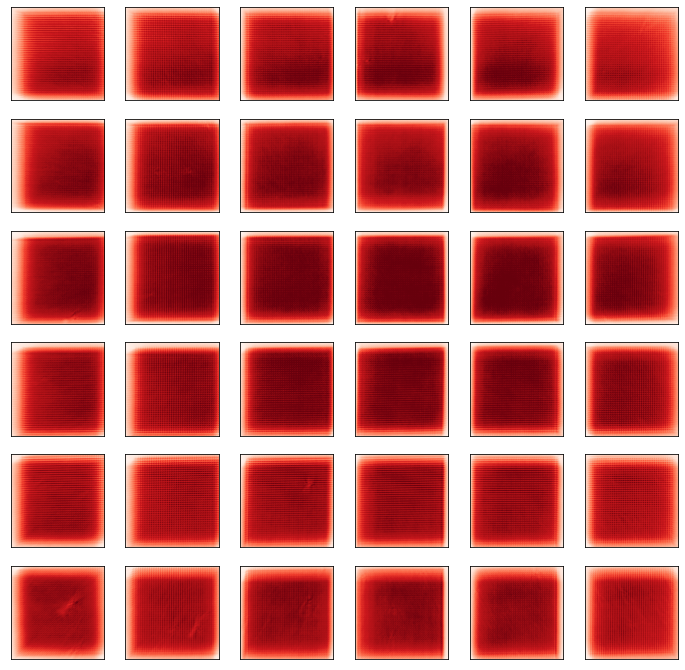

In [14]:
indices_before = np.stack((x_inds, y_inds.T), axis = -1).reshape(36, 2)
size = 133
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
for i in range (6):
    for j in range (6):
        ax[i, j].imshow(I0[indices_before[6*i + j][1]:indices_before[6*i + j][1] + size, \
                           indices_before[6*i + j][0]:indices_before[6*i + j][0] + size], cmap = 'Reds')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

In [15]:
#Loading Training + Validation set of QuickDraw

folder_path = "../Datasets/Quick_Draw_Dataset.npz"
DMD_Images = np.load(folder_path)['DMD_train']
print(DMD_Images.shape)
Final_DMD_Images = []
for i in range (DMD_Images.shape[0]):
    okl = DMD_Images[i]
    arr = np.zeros((200, 200))
    arr[int((arr.shape[0] - okl.shape[0])/2):int((arr.shape[0] + okl.shape[0])/2),\
      int((arr.shape[0] - okl.shape[1])/2):int((arr.shape[0] + okl.shape[1])/2)] = okl
    rot_fig = np.maximum(ndimage.rotate(np.fliplr(arr), -45, reshape = False), 0)
    rot_fig = np.minimum(rot_fig, 1)
    rot_fig = np.fliplr(np.flipud(rot_fig))
    array = np.zeros((800, 1280))
    array[int((800 - arr.shape[0])/2):int((800 + arr.shape[0])/2),\
          int((1280 - arr.shape[0])/2):int((1280 + arr.shape[0])/2)] = rot_fig
    array = (255.*(array)).astype(np.uint8)
    Final_DMD_Images.append(array)
Final_DMD_Images = np.array(Final_DMD_Images)
print(Final_DMD_Images.shape)

(3000, 100, 100)
(3000, 800, 1280)


In [16]:
#Updating the exposure time of monitoring camera 1
exp_bassler = 150000 #in usec

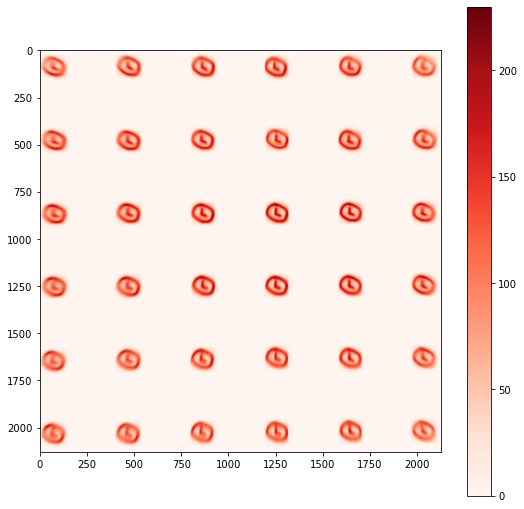

In [17]:
#Checking to see that everything is working properly while displaying QuickDraw images on the DMD

bitDepth = 1
# Allocate the onboard memory for the image sequence
DMD.SeqAlloc(nbImg = 1, bitDepth = bitDepth)
# Send the image sequence as a 1D list/array/numpy array
DMD.SeqPut(imgData = Final_DMD_Images[0].ravel())
DMD.Run()

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler
img_ls = bassler_cam.take_imgs(5)
image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]
bassler_cam.camera.Close()

plt.figure(figsize=(9,9))
plt.imshow(np.array(image), cmap = 'Reds')
plt.colorbar()
plt.show()

In [18]:
#Defining exposure time and region of interests for camera 3/final measurement camera

exp_t = 130
roi = (0,3200,0,2200)
rois = np.array([[1225, 1375, 1010, 1160], [1225, 1375, 1760, 1910], [1790, 1940, 1010, 1160], [1790, 1940, 1760, 1910]])

In [ ]:
#Must Run LCD2_Weights_Upload.ipynb before running the next cell!

PMUSBCam00


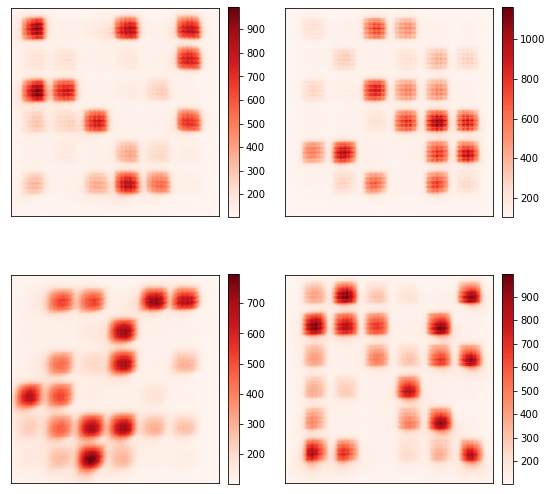

In [21]:
'''Taking an image of the weights of optical fully connected layer 2 after 
uploading the weights to LCD2 - see LCD2_Weights_Upload.ipynb'''

cam = next(Camera.detect_camera())
cam.open()
print(cam)

# Set up a directory to save all the data for one test image
unit_dic = {0:"ms", 1:"us"}

# Commands to take frames
count = 5
exposure_time = exp_t
exposure_time_res = 0
exposure_time_unit = 'µs' if exposure_time_res else 'ms'
cam.exp_res = exposure_time_res
cam.exp_time = exposure_time
#cam.roi = (0,3200,0,2200)  # Full ROI
cam.roi = roi
#cam.roi = (1321,1921,918,1518) # ROI for 1000x1000
imglist = cam.get_sequence(count) # get several frames
imglist = np.array(imglist)
image = np.mean(imglist, axis = 0)
# Disconnect from the camera
if cam.is_open:
    cam.close()
    
fig, ax = plt.subplots(2, 2, figsize = (9, 9))
for p in range (2):
    for q in range (2):
        im = ax[p, q].imshow(image[rois[2*p + q][0]:rois[2*p + q][1], rois[2*p + q][2]:rois[2*p + q][3]], cmap = 'Reds')
        plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
        ax[p, q].set_xticks([])
        ax[p, q].set_yticks([])
plt.show()
#np.savez('I0_reference_after_intensifier_DC.npz', image = image)
np.savez('Layer2_weights.npz', image = image)

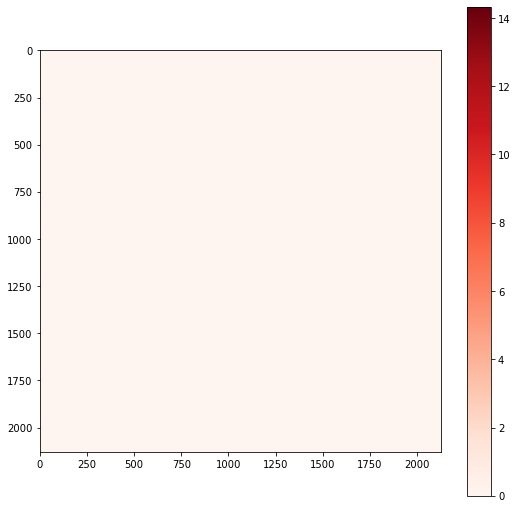

In [22]:
#Taking background reference images to subtract

arr = np.zeros((200, 200))
okl = np.zeros((100, 100))
arr[int((arr.shape[0] - okl.shape[0])/2):int((arr.shape[0] + okl.shape[0])/2),\
      int((arr.shape[0] - okl.shape[1])/2):int((arr.shape[0] + okl.shape[1])/2)] = okl
rot_fig = np.maximum(ndimage.rotate(np.fliplr(arr), -45, reshape = False), 0)
rot_fig = np.minimum(rot_fig, 1)
rot_fig = np.fliplr(np.flipud(rot_fig))
#scale_im = (rot_fig - np.min(rot_fig))/(np.max(rot_fig) - np.min(rot_fig))
array = np.zeros((800, 1280))
array[int((800 - arr.shape[0])/2):int((800 + arr.shape[0])/2),\
      int((1280 - arr.shape[0])/2):int((1280 + arr.shape[0])/2)] = rot_fig
array = (255.*(array)).astype(np.uint8)
bitDepth = 1
# Allocate the onboard memory for the image sequence
DMD.SeqAlloc(nbImg = 1, bitDepth = bitDepth)
# Send the image sequence as a 1D list/array/numpy array
DMD.SeqPut(imgData = array.ravel())
# Set image rate to 5 Hz
# DMD.SetTiming(pictureTime = 5000)
DMD.Run()

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler
img_ls = bassler_cam.take_imgs(25)
image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]
bassler_cam.camera.Close()

plt.figure(figsize=(9,9))
plt.imshow(np.array(image), cmap = 'Reds')
plt.colorbar()
plt.show()
np.savez('Noise_reference_before_intensifier_DC.npz', image = image)
noise = np.copy(image)

PMUSBCam00


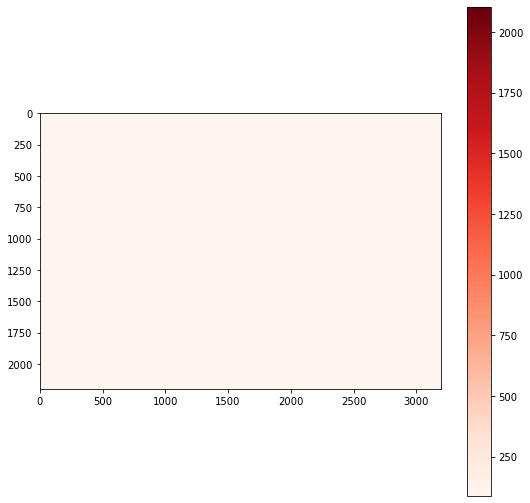

In [23]:
#Taking background reference images to subtract

cam = next(Camera.detect_camera())
cam.open()
print(cam)

# Set up a directory to save all the data for one test image
unit_dic = {0:"ms", 1:"us"}

# Commands to take frames
count = 5
exposure_time = exp_t
exposure_time_res = 0
exposure_time_unit = 'µs' if exposure_time_res else 'ms'
cam.exp_res = exposure_time_res
cam.exp_time = exposure_time
#cam.roi = (0,3200,0,2200)  # Full ROI
cam.roi = roi
#cam.roi = (1321,1921,918,1518) # ROI for 1000x1000
imglist = cam.get_sequence(count) # get several frames
imglist = np.array(imglist)
image = np.mean(imglist, axis = 0)
# Disconnect from the camera
if cam.is_open:
    cam.close()
    
plt.figure(figsize=(9,9))
plt.imshow(np.array(image), cmap = 'Reds')
plt.colorbar()
plt.show()
noise_after = np.copy(image)
np.savez('Noise_reference_after_intensifier_DC.npz', image = image)

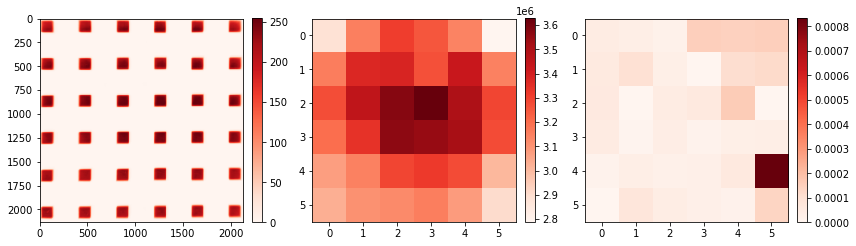

In [24]:
#Computing maximum transmisison values and background values for computing the normalized RMSE error

I0_vec = []
noise_vec = []

for i in range(indices_before.shape[0]):
    temp2 = np.mean(noise[indices_before[i, 1]:\
                               indices_before[i, 1] + size, \
                               indices_before[i, 0]:\
                               indices_before[i, 0] + size])
    temp = I0[indices_before[i, 1]:\
                               indices_before[i, 1] + size, \
                               indices_before[i, 0]:\
                               indices_before[i, 0] + size] - temp2
    I0_vec.append(np.sum(temp))
    noise_vec.append(temp2)
I0_vec = np.array(I0_vec)
noise_vec = np.array(noise_vec)

fig, ax = plt.subplots(1, 3, figsize = (12, 12))
im = ax[0].imshow(I0, cmap = 'Reds')
plt.colorbar(im, ax = ax[0], fraction=0.046, pad=0.04)
im = ax[1].imshow(I0_vec.reshape(6, 6), cmap = 'Reds')
plt.colorbar(im, ax = ax[1], fraction=0.046, pad=0.04)
im = ax[2].imshow(noise_vec.reshape(6, 6), cmap = 'Reds')
plt.colorbar(im, ax = ax[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

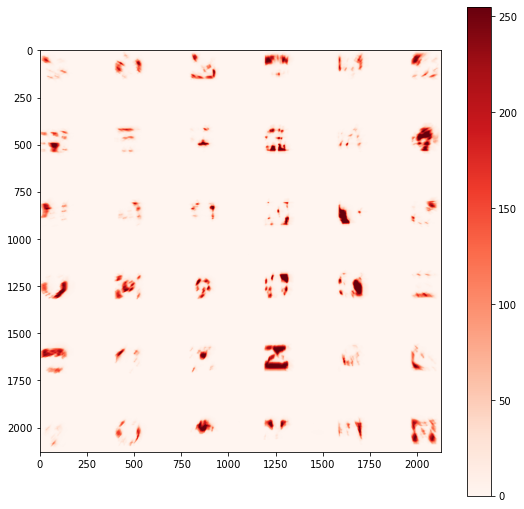

In [25]:
#Uploading weights for optical fully connected layer 1 and taking an image of them

ind = 1
array = np.zeros((n_cols, n_rows))
top_left_corner = [387, 409]
width = 40
spacing = 62.3
a = 0
b = 3
for i in range (-5, 6):
    for j in range (-5, 7):
        p = i + 5
        q = 5 + j
        if(p in [0, 2, 4, 6, 8, 10] and q in [1, 3, 5, 7, 9, 11]):
            a = int(p/2)
            b = int((11 - q)/2)
            array[top_left_corner[0] + int(i*spacing) + movements[6*a + b][0] \
                  : top_left_corner[0] + width + int(i*spacing) + movements[6*a + b][0], \
                  top_left_corner[1] + int(j*spacing) + movements[6*a + b][1] \
                  : top_left_corner[1] + width + int(j*spacing) + movements[6*a + b][1]] = \
            np.fliplr(LCD_weights[6*a + b].reshape(40, 40))       
array = (array).astype(np.uint8)
Sony.updateArray(array)

arr = np.zeros((200, 200))
okl = np.ones((100, 100))
arr[int((arr.shape[0] - okl.shape[0])/2):int((arr.shape[0] + okl.shape[0])/2),\
      int((arr.shape[0] - okl.shape[1])/2):int((arr.shape[0] + okl.shape[1])/2)] = okl
rot_fig = np.maximum(ndimage.rotate(np.fliplr(arr), -45, reshape = False), 0)
rot_fig = np.minimum(rot_fig, 1)
rot_fig = np.fliplr(np.flipud(rot_fig))
scale_im = (rot_fig - np.min(rot_fig))/(np.max(rot_fig) - np.min(rot_fig))
array = np.zeros((800, 1280))
array[int((800 - arr.shape[0])/2):int((800 + arr.shape[0])/2),\
      int((1280 - arr.shape[0])/2):int((1280 + arr.shape[0])/2)] = scale_im
array = (255.*(array)).astype(np.uint8)
bitDepth = 1
# Allocate the onboard memory for the image sequence
DMD.SeqAlloc(nbImg = 1, bitDepth = bitDepth)
# Send the image sequence as a 1D list/array/numpy array
DMD.SeqPut(imgData = array.ravel())
# Set image rate to 5 Hz
# DMD.SetTiming(pictureTime = 5000)
DMD.Run()

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler
img_ls = bassler_cam.take_imgs(5)
image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]
bassler_cam.camera.Close()
    
plt.figure(figsize=(9,9))
plt.imshow(np.array(image), cmap = 'Reds')
plt.colorbar()
plt.show()
np.savez(f'Weights_im.npz', image = image)

In [26]:
#Updating exposure time of first monitoring camera and define data collection folder
fder = 'Data'
exp_bassler = 170000

In [ ]:
#Check to see that both LCDs have the correct weights uploaded

PMUSBCam00
Beginning Data Collection


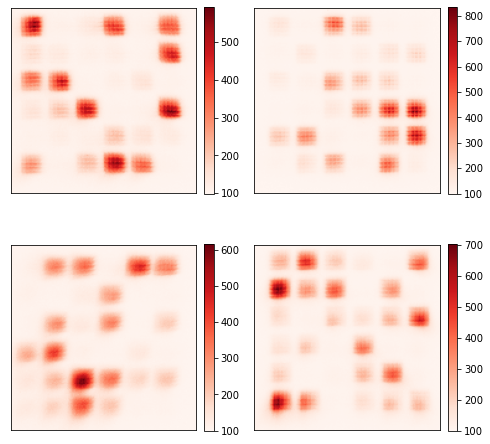

0\% completed


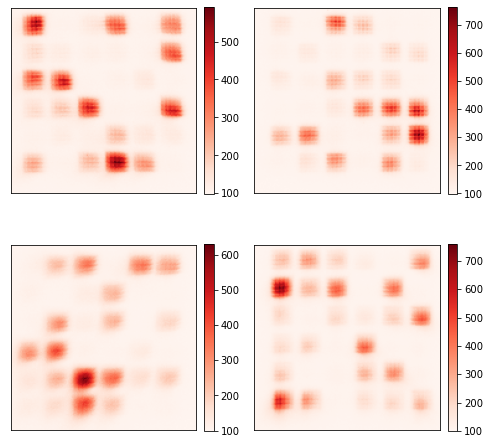

3\% completed


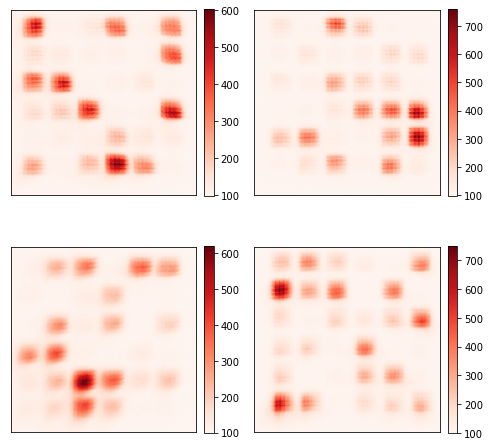

6\% completed


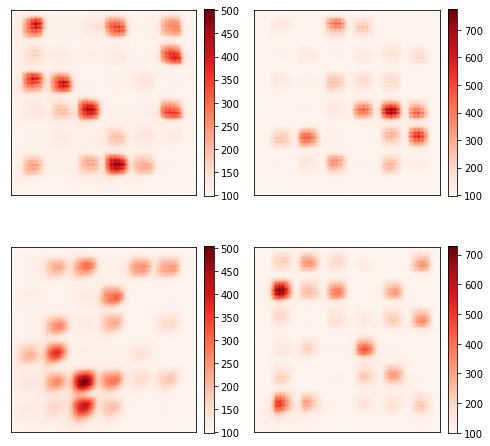

10\% completed


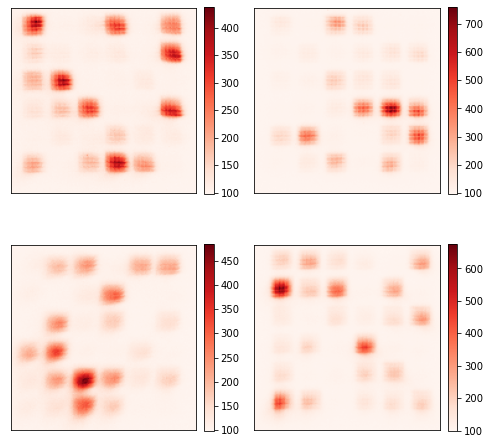

13\% completed


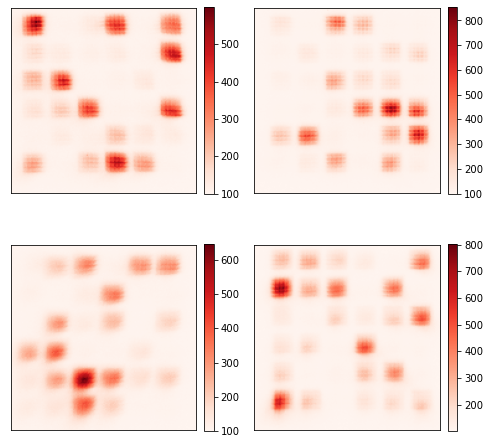

16\% completed


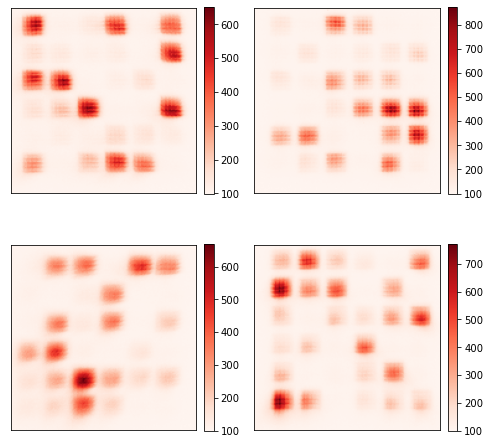

20\% completed


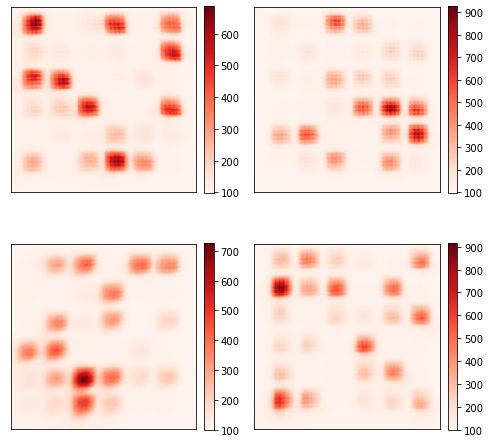

23\% completed


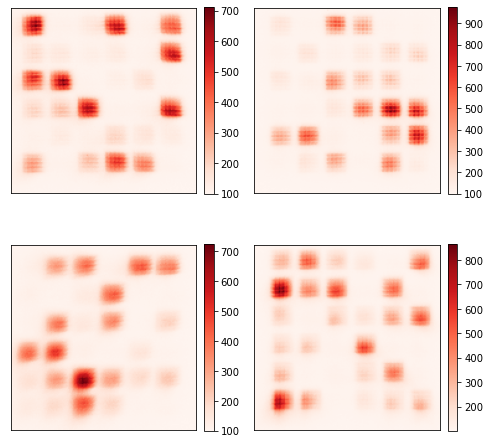

26\% completed


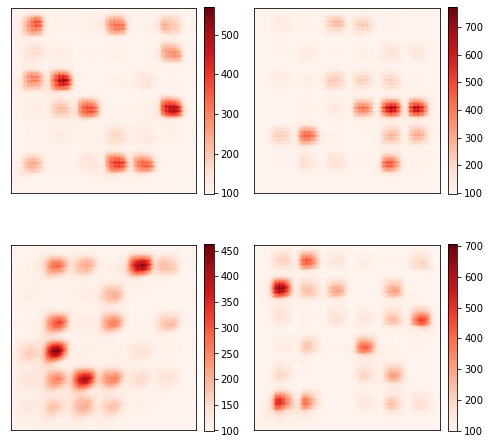

30\% completed


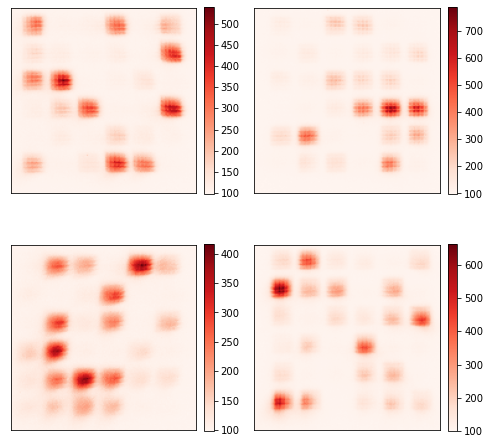

33\% completed


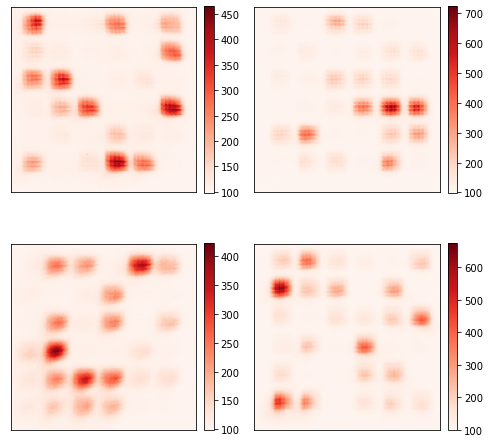

36\% completed


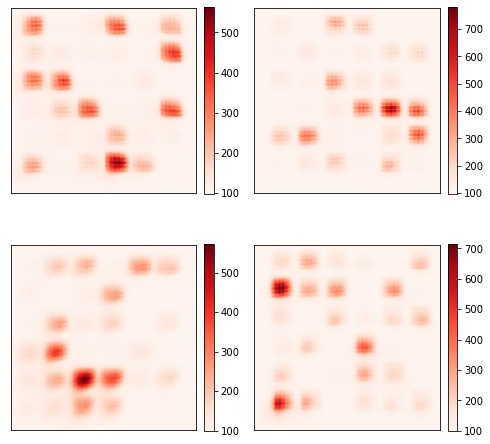

40\% completed


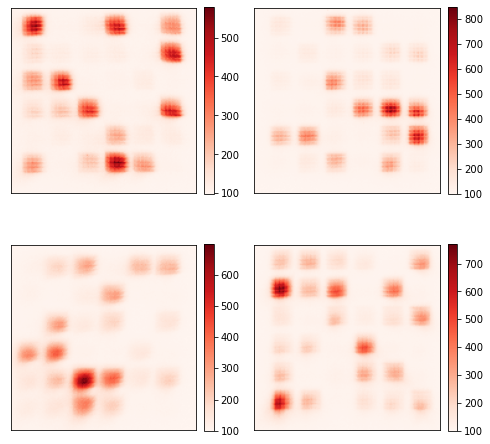

43\% completed


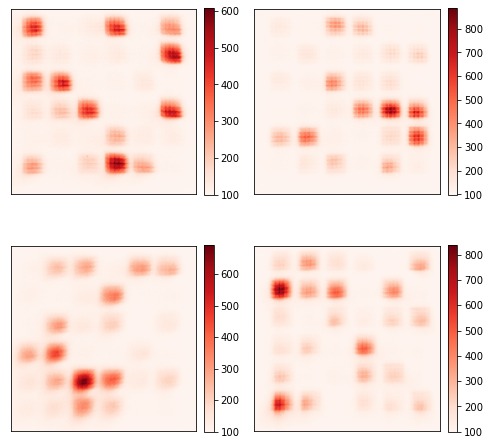

46\% completed


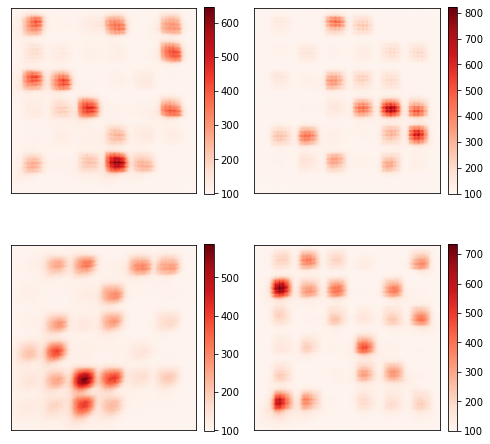

50\% completed


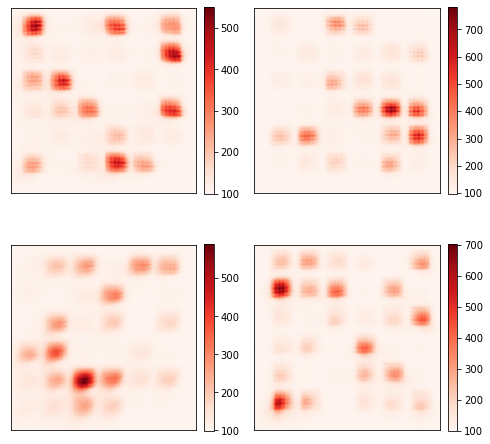

53\% completed


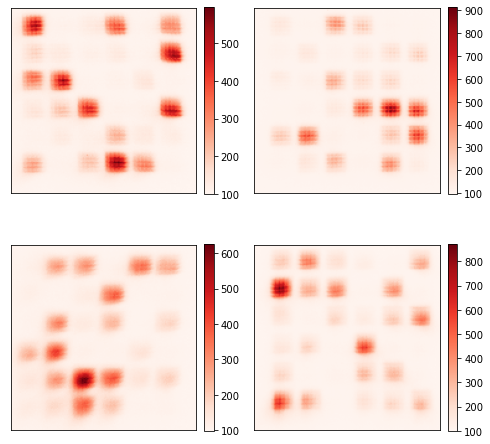

56\% completed


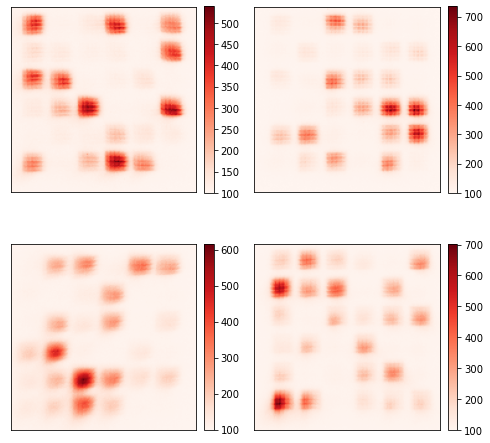

60\% completed


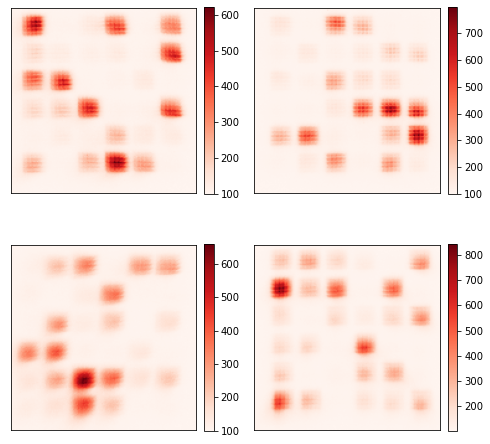

63\% completed


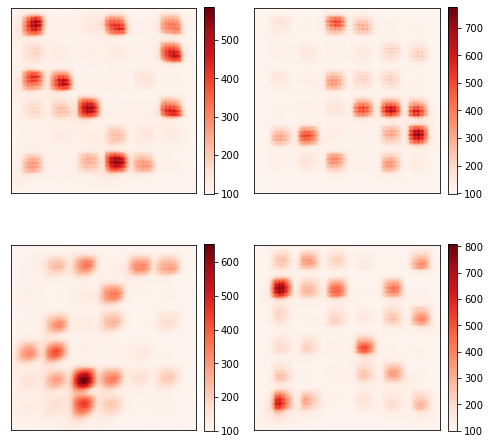

66\% completed


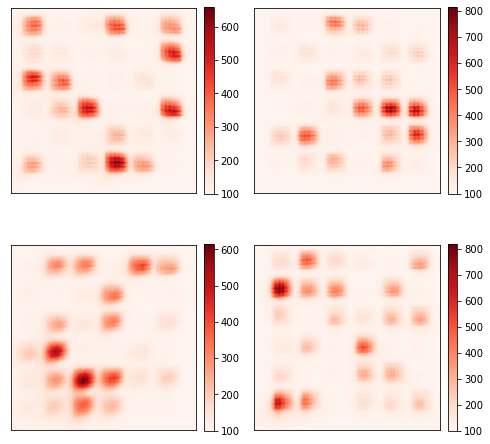

70\% completed


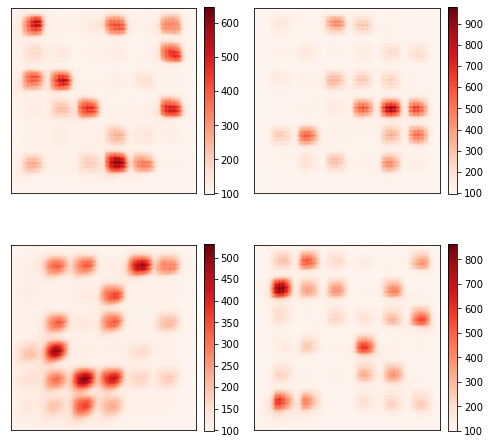

73\% completed


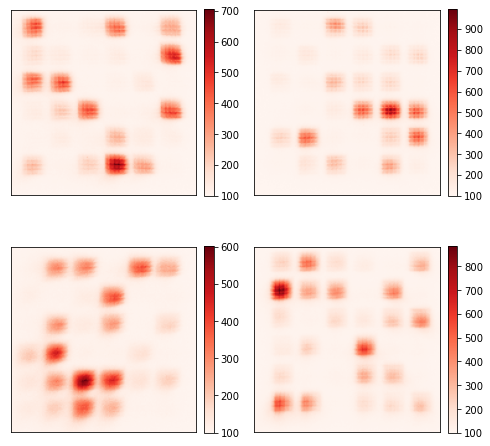

76\% completed


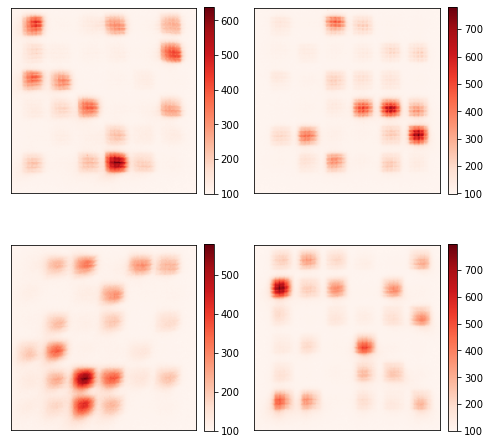

80\% completed


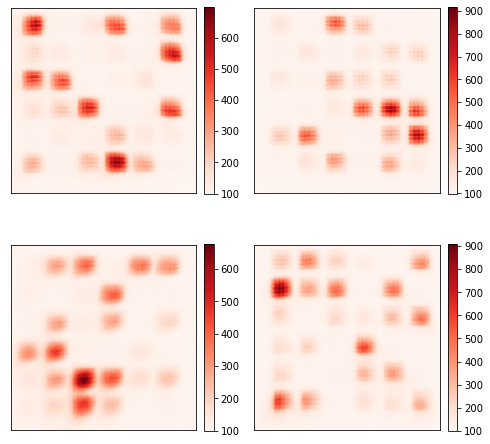

83\% completed


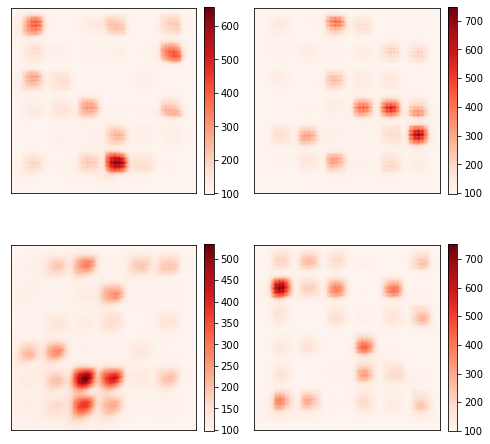

86\% completed


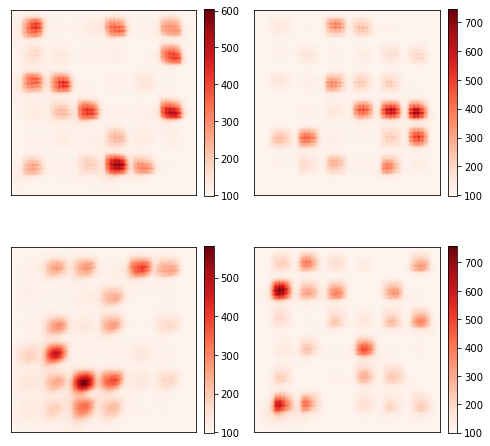

90\% completed


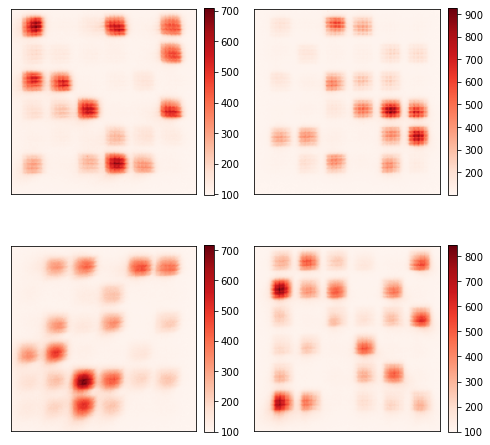

93\% completed


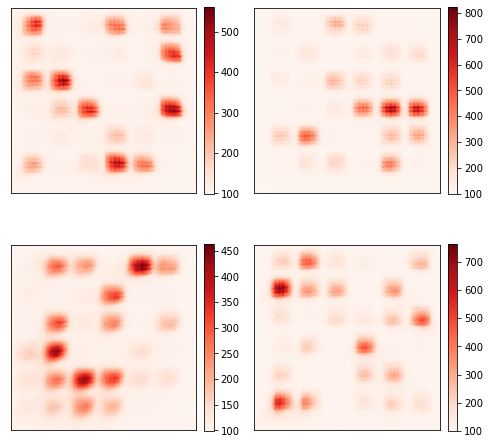

96\% completed
Finished Data Collection


In [27]:
#Collect Training + Validation Data after passing through the optical neural network

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler

cam = next(Camera.detect_camera())
cam.open()
print(cam)

# Set up a directory to save all the data for one test image
unit_dic = {0:"ms", 1:"us"}

# Commands to take frames
count = 3
exposure_time = exp_t
exposure_time_res = 0
exposure_time_unit = 'µs' if exposure_time_res else 'ms'
cam.exp_res = exposure_time_res
cam.exp_time = exposure_time
#cam.roi = (0,3200,0,2200)  # Full ROI
cam.roi = roi
#cam.roi = (1321,1921,918,1518) # ROI for 1000x1000


print(f'Beginning Data Collection')
for i in range(0, Final_DMD_Images.shape[0]):
    DMD.SeqAlloc(nbImg = 1, bitDepth = 1)
    DMD.SeqPut(imgData = Final_DMD_Images[i].ravel())
    DMD.Run()
    time.sleep(0.02)

#     img_ls = bassler_cam.take_imgs(2)
#     image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]

#     time.sleep(0.1)

    img = cam.get_sequence(count)
    img = np.mean(np.array(img), axis = 0) #get average of 'count' frames
    
    time.sleep(0.02)
    
    if (i%100 == 0):
#         fig, ax = plt.subplots(6, 6, figsize = (12, 12))
#         for p in range (6):
#             for q in range (6):
#                 im = ax[p, q].imshow(image[indices_before[6*p + q][1]:indices_before[6*p + q][1] + size, \
#                                    indices_before[6*p + q][0]:indices_before[6*p + q][0] + size], cmap = 'Reds')
#                 plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
#                 ax[p, q].set_xticks([])
#                 ax[p, q].set_yticks([])
#         plt.show()
        fig, ax = plt.subplots(2, 2, figsize = (8, 8))
        for p in range (2):
            for q in range (2):
                im = ax[p, q].imshow(img[rois[2*p + q][0]:rois[2*p + q][1], rois[2*p + q][2]:rois[2*p + q][3]], cmap = 'Reds')
                plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
                ax[p, q].set_xticks([])
                ax[p, q].set_yticks([])
        plt.show()
        print(f'{int(100*i/Final_DMD_Images.shape[0])}\% completed')
    if (i == 0):
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size] - \
#                    noise[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             if (p == 0):
#                 np.savetxt(fder + f'\Train_Nonlinear_Data_before_intensifier.csv', temp.astype(np.uint8), delimiter = ',')
#             else:
#                 f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#                 np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#                 f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            if (q == 0):
                np.savetxt(fder + f'\Train_Nonlinear_Data_after_intensifier.csv', temp2.astype(np.uint16), delimiter = ',')
            else :
                f=open(fder + f'\Train_Nonlinear_Data_after_intensifier.csv','ab')
                np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
                f.close()
    else:
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#             np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#             f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            f=open(fder + f'\Train_Nonlinear_Data_after_intensifier.csv','ab')
            np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
            f.close()
print(f'Finished Data Collection')

bassler_cam.camera.Close()
# Disconnect from the camera
if cam.is_open:
    cam.close()

In [25]:
#In case camera disconnects during above loop, copy index 
a = np.copy(i)
print(i)

bassler_cam.camera.Close()
# Disconnect from the camera
if cam.is_open:
    cam.close()

0


In [40]:
#continue data collection from copied index

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler

cam = next(Camera.detect_camera())
cam.open()
print(cam)

# Set up a directory to save all the data for one test image
unit_dic = {0:"ms", 1:"us"}

# Commands to take frames
count = 3
exposure_time = exp_t
exposure_time_res = 0
exposure_time_unit = 'µs' if exposure_time_res else 'ms'
cam.exp_res = exposure_time_res
cam.exp_time = exposure_time
#cam.roi = (0,3200,0,2200)  # Full ROI
cam.roi = roi
#cam.roi = (1321,1921,918,1518) # ROI for 1000x1000


print(f'Beginning Data Collection')
for i in range(a, Final_DMD_Images.shape[0]):
    DMD.SeqAlloc(nbImg = 1, bitDepth = 1)
    DMD.SeqPut(imgData = Final_DMD_Images[i].ravel())
    DMD.Run()
    time.sleep(0.02)

#     img_ls = bassler_cam.take_imgs(2)
#     image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]

#     time.sleep(0.1)

    img = cam.get_sequence(count)
    img = np.mean(np.array(img), axis = 0) #get average of 'count' frames
    
    time.sleep(0.02)
    
    if (i%100 == 0):
#         fig, ax = plt.subplots(6, 6, figsize = (12, 12))
#         for p in range (6):
#             for q in range (6):
#                 im = ax[p, q].imshow(image[indices_before[6*p + q][1]:indices_before[6*p + q][1] + size, \
#                                    indices_before[6*p + q][0]:indices_before[6*p + q][0] + size], cmap = 'Reds')
#                 plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
#                 ax[p, q].set_xticks([])
#                 ax[p, q].set_yticks([])
#         plt.show()
        fig, ax = plt.subplots(2, 2, figsize = (8, 8))
        for p in range (2):
            for q in range (2):
                im = ax[p, q].imshow(img[rois[2*p + q][0]:rois[2*p + q][1], rois[2*p + q][2]:rois[2*p + q][3]], cmap = 'Reds')
                plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
                ax[p, q].set_xticks([])
                ax[p, q].set_yticks([])
        plt.show()
        print(f'{int(100*i/Final_DMD_Images.shape[0])}\% completed')
    if (i == 0):
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size] - \
#                    noise[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             if (p == 0):
#                 np.savetxt(fder + f'\Train_Nonlinear_Data_before_intensifier.csv', temp.astype(np.uint8), delimiter = ',')
#             else:
#                 f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#                 np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#                 f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            if (q == 0):
                np.savetxt(fder + f'\Train_Nonlinear_Data_after_intensifier.csv', temp2.astype(np.uint16), delimiter = ',')
            else :
                f=open(fder + f'\Train_Nonlinear_Data_after_intensifier.csv','ab')
                np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
                f.close()
    else:
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#             np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#             f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            f=open(fder + f'\Train_Nonlinear_Data_after_intensifier.csv','ab')
            np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
            f.close()
print(f'Finished Data Collection')

bassler_cam.camera.Close()
# Disconnect from the camera
if cam.is_open:
    cam.close()

PMUSBCam00
Finished Data Collection  for weight 1


In [28]:
#Load test data to display on DMD

folder_path = "../Datasets/Quick_Draw_Dataset.npz"
DMD_Images = np.load(folder_path)['DMD_test']
print(DMD_Images.shape)
Final_DMD_Images = []
for i in range (DMD_Images.shape[0]):
    okl = DMD_Images[i]
    arr = np.zeros((200, 200))
    arr[int((arr.shape[0] - okl.shape[0])/2):int((arr.shape[0] + okl.shape[0])/2),\
      int((arr.shape[0] - okl.shape[1])/2):int((arr.shape[0] + okl.shape[1])/2)] = okl
    rot_fig = np.maximum(ndimage.rotate(np.fliplr(arr), -45, reshape = False), 0)
    rot_fig = np.minimum(rot_fig, 1)
    rot_fig = np.fliplr(np.flipud(rot_fig))
    array = np.zeros((800, 1280))
    array[int((800 - arr.shape[0])/2):int((800 + arr.shape[0])/2),\
          int((1280 - arr.shape[0])/2):int((1280 + arr.shape[0])/2)] = rot_fig
    array = (255.*(array)).astype(np.uint8)
    Final_DMD_Images.append(array)
Final_DMD_Images = np.array(Final_DMD_Images)
print(Final_DMD_Images.shape)

(505, 100, 100)
(505, 800, 1280)


PMUSBCam00
Beginning Data Collection


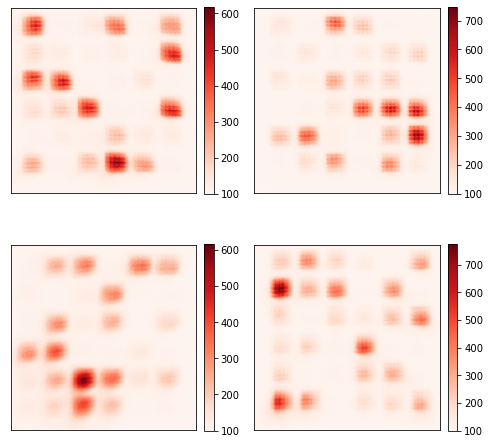

0\% completed


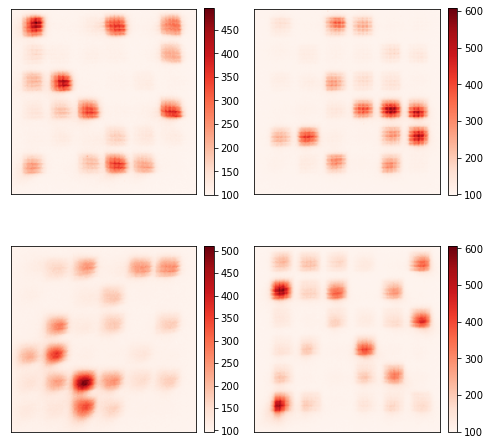

19\% completed


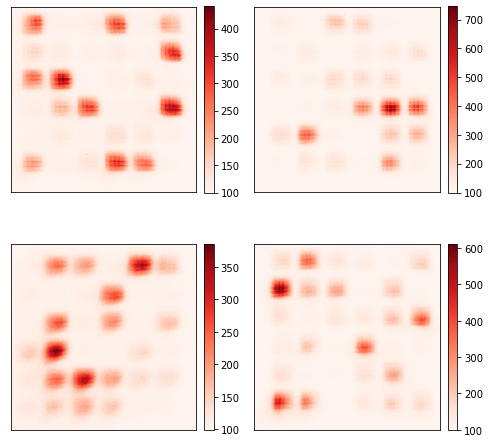

39\% completed


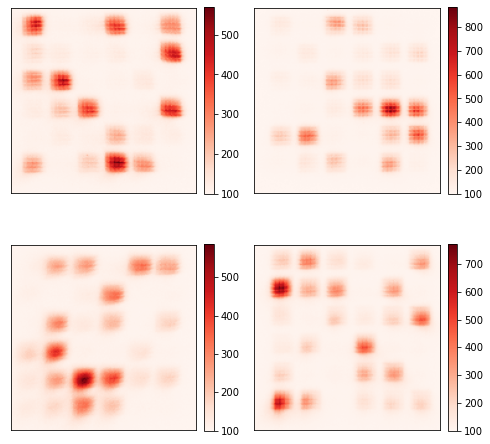

59\% completed


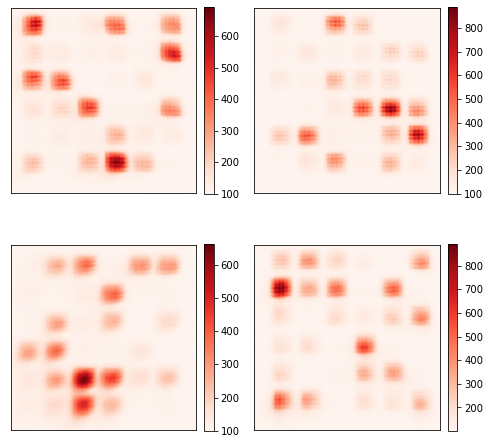

79\% completed


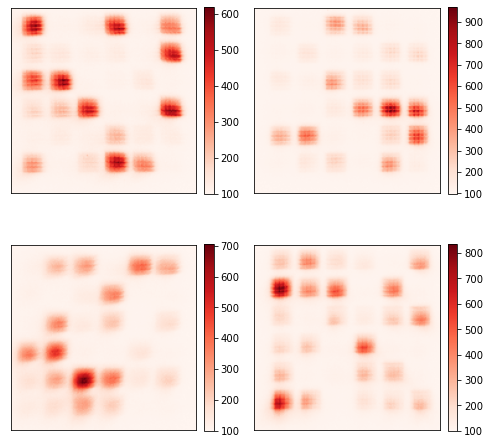

99\% completed
Finished Data Collection


In [29]:
#Collect Testing Data after passing through the optical neural network

bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler

cam = next(Camera.detect_camera())
cam.open()
print(cam)

# Set up a directory to save all the data for one test image
unit_dic = {0:"ms", 1:"us"}

# Commands to take frames
count = 3
exposure_time = exp_t
exposure_time_res = 0
exposure_time_unit = 'µs' if exposure_time_res else 'ms'
cam.exp_res = exposure_time_res
cam.exp_time = exposure_time
#cam.roi = (0,3200,0,2200)  # Full ROI
cam.roi = roi
#cam.roi = (1321,1921,918,1518) # ROI for 1000x1000


print(f'Beginning Data Collection')
for i in range(0, Final_DMD_Images.shape[0]):
    DMD.SeqAlloc(nbImg = 1, bitDepth = 1)
    DMD.SeqPut(imgData = Final_DMD_Images[i].ravel())
    DMD.Run()
    time.sleep(0.02)

#     img_ls = bassler_cam.take_imgs(2)
#     image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]

#     time.sleep(0.1)

    img = cam.get_sequence(count)
    img = np.mean(np.array(img), axis = 0) #get average of 'count' frames
    
    time.sleep(0.02)
    
    if (i%100 == 0):
#         fig, ax = plt.subplots(6, 6, figsize = (12, 12))
#         for p in range (6):
#             for q in range (6):
#                 im = ax[p, q].imshow(image[indices_before[6*p + q][1]:indices_before[6*p + q][1] + size, \
#                                    indices_before[6*p + q][0]:indices_before[6*p + q][0] + size], cmap = 'Reds')
#                 plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
#                 ax[p, q].set_xticks([])
#                 ax[p, q].set_yticks([])
#         plt.show()
        fig, ax = plt.subplots(2, 2, figsize = (8, 8))
        for p in range (2):
            for q in range (2):
                im = ax[p, q].imshow(img[rois[2*p + q][0]:rois[2*p + q][1], rois[2*p + q][2]:rois[2*p + q][3]], cmap = 'Reds')
                plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
                ax[p, q].set_xticks([])
                ax[p, q].set_yticks([])
        plt.show()
        print(f'{int(100*i/Final_DMD_Images.shape[0])}\% completed')
    if (i == 0):
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size] - \
#                    noise[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             if (p == 0):
#                 np.savetxt(fder + f'\Train_Nonlinear_Data_before_intensifier.csv', temp.astype(np.uint8), delimiter = ',')
#             else:
#                 f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#                 np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#                 f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            if (q == 0):
                np.savetxt(fder + f'\Test_Nonlinear_Data_after_intensifier.csv', temp2.astype(np.uint16), delimiter = ',')
            else :
                f=open(fder + f'\Test_Nonlinear_Data_after_intensifier.csv','ab')
                np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
                f.close()
    else:
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#             np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#             f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            f=open(fder + f'\Test_Nonlinear_Data_after_intensifier.csv','ab')
            np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
            f.close()
print(f'Finished Data Collection')

bassler_cam.camera.Close()
# Disconnect from the camera
if cam.is_open:
    cam.close()

In [51]:
a = np.copy(i)
print(i)

bassler_cam.camera.Close()
# Disconnect from the camera
if cam.is_open:
    cam.close()

152


PMUSBCam00
Beginning Data Collection


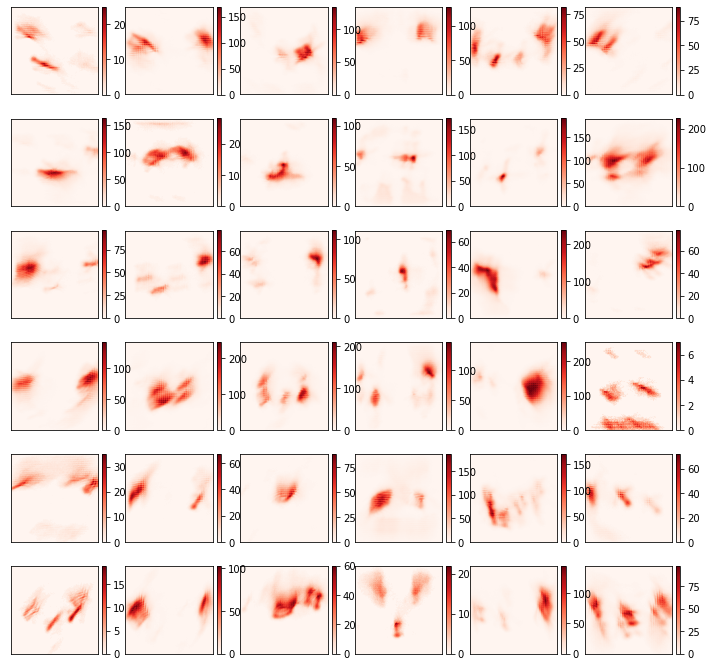

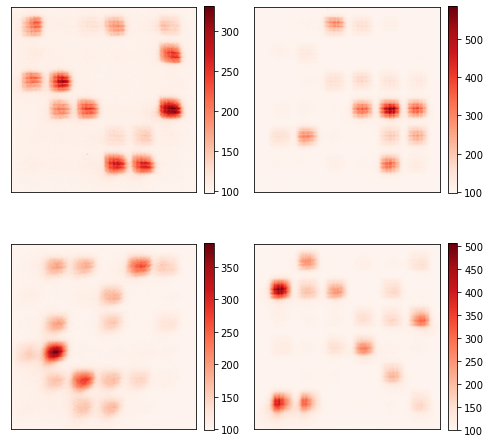

39\% completed


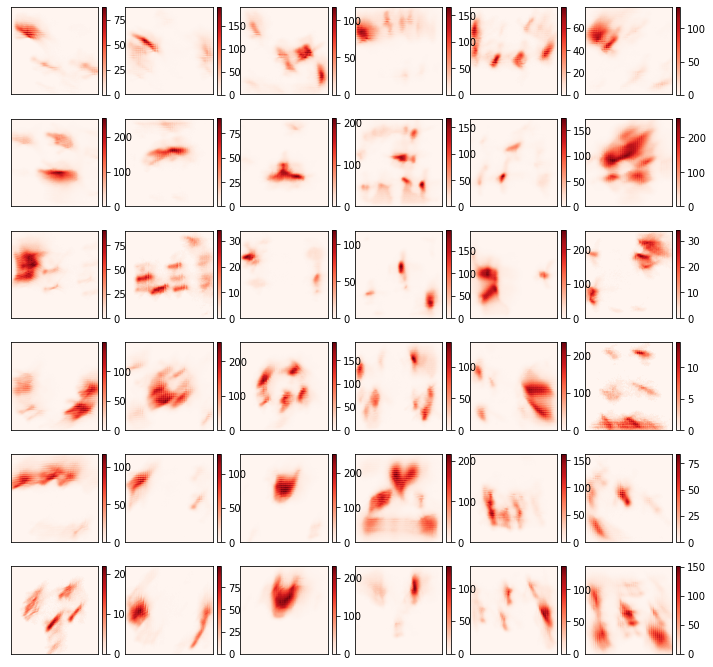

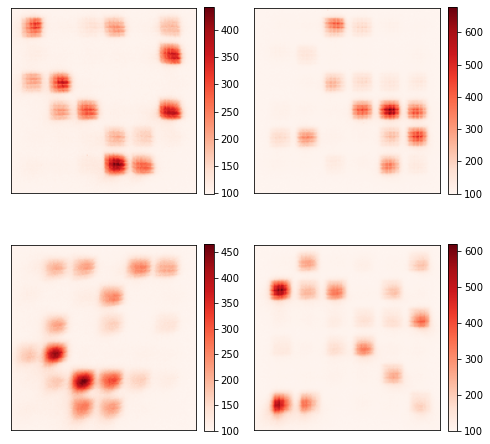

59\% completed


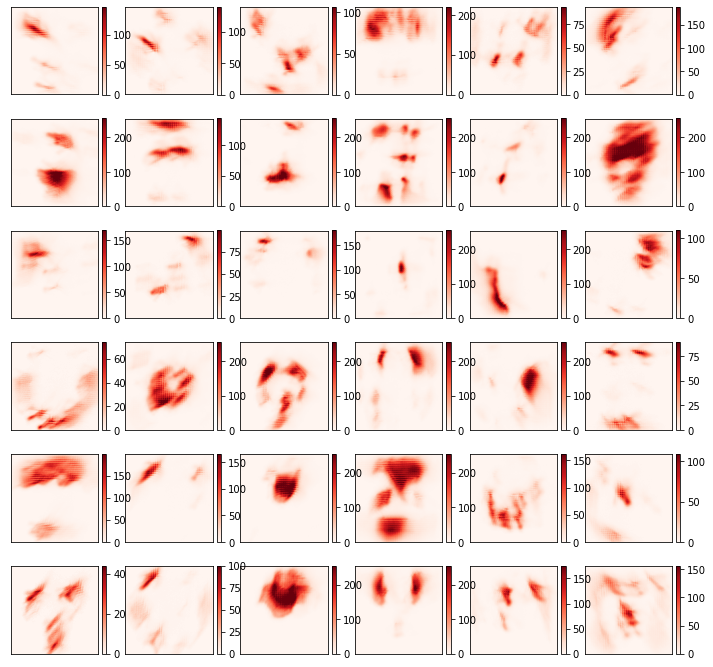

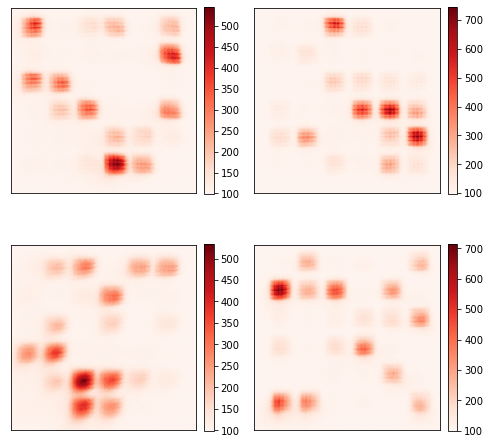

79\% completed


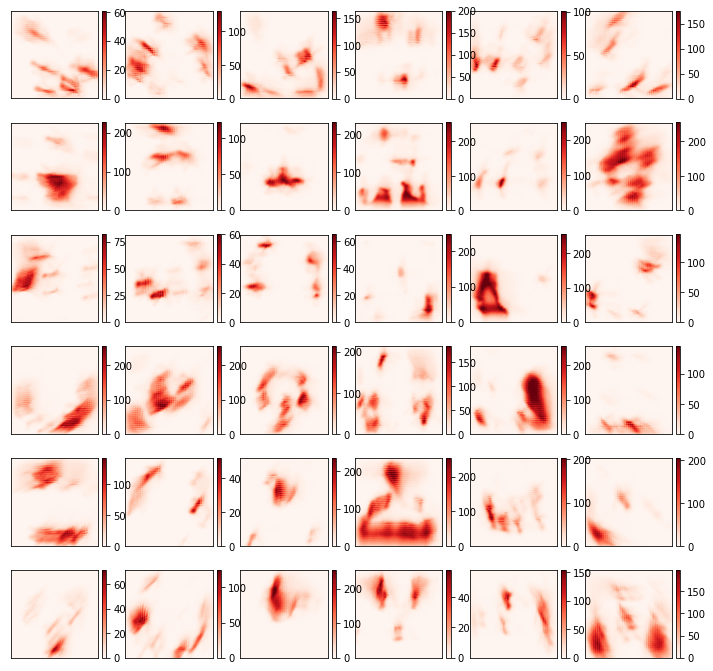

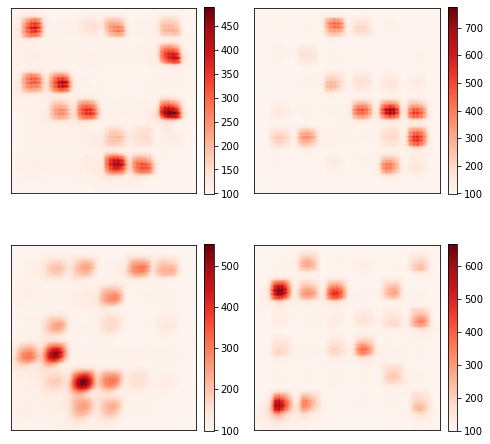

99\% completed
Finished Data Collection


In [52]:
bassler_cam = Spectrometer(devices[0])
bassler_cam.exposure_time = exp_bassler

cam = next(Camera.detect_camera())
cam.open()
print(cam)

# Set up a directory to save all the data for one test image
unit_dic = {0:"ms", 1:"us"}

# Commands to take frames
count = 3
exposure_time = exp_t
exposure_time_res = 0
exposure_time_unit = 'µs' if exposure_time_res else 'ms'
cam.exp_res = exposure_time_res
cam.exp_time = exposure_time
#cam.roi = (0,3200,0,2200)  # Full ROI
cam.roi = roi
#cam.roi = (1321,1921,918,1518) # ROI for 1000x1000


print(f'Beginning Data Collection')
for i in range(a, Final_DMD_Images.shape[0]):
    DMD.SeqAlloc(nbImg = 1, bitDepth = 1)
    DMD.SeqPut(imgData = Final_DMD_Images[i].ravel())
    DMD.Run()
    time.sleep(0.02)

#     img_ls = bassler_cam.take_imgs(2)
#     image = np.mean(img_ls, axis = 0)[roi_bassler[0]:roi_bassler[1], roi_bassler[2]:roi_bassler[3]]

#     time.sleep(0.1)

    img = cam.get_sequence(count)
    img = np.mean(np.array(img), axis = 0) #get average of 'count' frames
    
    time.sleep(0.02)
    
    if (i%100 == 0):
#         fig, ax = plt.subplots(6, 6, figsize = (12, 12))
#         for p in range (6):
#             for q in range (6):
#                 im = ax[p, q].imshow(image[indices_before[6*p + q][1]:indices_before[6*p + q][1] + size, \
#                                    indices_before[6*p + q][0]:indices_before[6*p + q][0] + size], cmap = 'Reds')
#                 plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
#                 ax[p, q].set_xticks([])
#                 ax[p, q].set_yticks([])
#         plt.show()
        fig, ax = plt.subplots(2, 2, figsize = (8, 8))
        for p in range (2):
            for q in range (2):
                im = ax[p, q].imshow(img[rois[2*p + q][0]:rois[2*p + q][1], rois[2*p + q][2]:rois[2*p + q][3]], cmap = 'Reds')
                plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
                ax[p, q].set_xticks([])
                ax[p, q].set_yticks([])
        plt.show()
        print(f'{int(100*i/Final_DMD_Images.shape[0])}\% completed')
    if (i == 0):
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size] - \
#                    noise[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             if (p == 0):
#                 np.savetxt(fder + f'\Train_Nonlinear_Data_before_intensifier.csv', temp.astype(np.uint8), delimiter = ',')
#             else:
#                 f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#                 np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#                 f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            if (q == 0):
                np.savetxt(fder + f'\Test_Nonlinear_Data_after_intensifier.csv', temp2.astype(np.uint16), delimiter = ',')
            else :
                f=open(fder + f'\Test_Nonlinear_Data_after_intensifier.csv','ab')
                np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
                f.close()
    else:
#         for p in range (36):
#             temp = image[indices_before[p][1]:indices_before[p][1] + size, \
#                          indices_before[p][0]:indices_before[p][0] + size]
#             f=open(fder + f'\Train_Nonlinear_Data_before_intensifier.csv','ab')
#             np.savetxt(f, temp.astype(np.uint8), delimiter = ',')
#             f.close()
        for q in range (4):
            temp2 = img[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]] - \
                    noise_after[rois[q][0]:rois[q][1], rois[q][2]:rois[q][3]]
            f=open(fder + f'\Test_Nonlinear_Data_after_intensifier.csv','ab')
            np.savetxt(f, temp2.astype(np.uint16), delimiter = ',')
            f.close()
print(f'Finished Data Collection')

bassler_cam.camera.Close()
# Disconnect from the camera
if cam.is_open:
    cam.close()

In [30]:
# Stop the sequence display
DMD.Halt()
# Free the sequence from the onboard memory
DMD.FreeSeq()

In [31]:
#Close LCD
Sony.close()